# Searching for and Plotting Lightcurves of Eclipsing Binary Stars

***

## Learning Goals
>Write three to five learning goals. A learning goal should describe what a reader should know or be able to do by the >end of the tutorial that they didn't know or couldn't do before.

By the end of this tutorial, you will:

- Use `astroquery` to load the APOGEE Binary Radial Velocity catalog from `Vizier` and narrow down a list of stellar binaries by a set of parameters. 
- Determine if a stellar system in the APOGEE catalog has lightcurve in the TESS Data for Asteroseismology Lightcurves archive from TASOC (the TESS Asterosesmic Science Operations Center) or in the TESS Lightcurves From The MIT Quick-Look Pipeline ("QLP") archive. 
- Download and plot a lightcurve file using `astroquery.mast`.
- Download, plot, and find the eclipsing binary period of a collection of the lightcurves using `lightkurve`.

## Introduction
Just like extrasolar planets, binary star systems can be discovered by multiple methods. Three of the methods include:

1. Astrometry (explain, visual binary)
2. Radial velocity (explain, spectroscopic binary)
3. Eclipses. 

 Apache Point Observatory Galactic Evolution Experiment, APOGEE-1 and APOGEE-2

Notes: 
- Define eclipse, transit, binary, multiple. Asteroseismology! 
- The observations/missions used
- The Apache Point Observatory Galactic Evolution Experiment, APOGEE-1 and APOGEE-2 surveys... https://www.sdss.org/surveys/apogee-2/ 
- Something about, do binary system candidates identified with RV also have TESS lightcurves that show eclipses. What info can be gathered from each type of observation and why eclipse would add more information. Narrow down to e.g. short orbital periods, why most likely to find it with that. Choose ones that do it. 

In this tutorial, we will load a catalog of binary stellar systems discovered through the radial velocity method and investigate if those systems have also have lightcurves from the TESS mission that observed eclipsing. Though we'll focus on a narrow set of eclipsing binaries with previously-measured properties, the radial velocity catalog we'll be working with has nearly 5000 stellar systems that are yet to be fully characterized. 


## Imports

- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data
- *astroquery.mast Observations* for querying MAST for observations
- *astroquery.vizier Vizier* for querying Vizier for published tables
- *lightkurve* for plotting and analying TESS lightcurves from the QLP or TASOC archives hosted on MASS

You may need to [install the ```lightkurve``` package using its quickstart guide](https://docs.lightkurve.org/quickstart.html). 

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astroquery.mast import Observations
# Above were from the template, JRK review which ones end up applicable.
from astroquery.vizier import Vizier
import lightkurve as lk

***

## Loading the APOGEE Binary Radial Velocity catalog from VizieR

The catalogs and data tables produced for astrophysical publications in refereed journals are made accessible in digital form through the CDS VizieR catalog service. First, we'll use astroquery to find the tables associated with [Price-Whelan et al. 2018 (AJ, 156, 1, 18)](https://ui.adsabs.harvard.edu/abs/2018AJ....156...18P/abstract), a catalog of ~5000 binary compansions of evolved stars in APOGEE DR14. 

>Loading data and file information should appear within your main content, at the same time the data is going to be used, if possible. These elements of your tutorial can be their own sections within the main content, but avoid generic or vague headings like “Loading Data” and instead use descriptive headings pertinent to the content of the tutorial and the actual data being downloaded or files being used.

>If the user needs to download data to run the tutorial properly, where possible, use [Astroquery](https://astroquery.readthedocs.io/en/latest/) (or similar) to retrieve files. If this is not possible, see the [data guide](https://github.com/spacetelescope/style-guides/blob/master/guides/where-to-put-your-data.md) for other options.

If we didn't know the the specific 'key' or unique string that identifies the dataset we want, we could query Vizier by the author name. In the first query below, ```catalog_list1``` is an ordered dictionary. Alternatively, we could search for any catalogs that could be found with the key words 'APOGEE' and 'binary,' as we do for catalog_list2.

In [2]:
catalog_list1 = Vizier.find_catalogs('Price-Whelan') 
print(str(len(catalog_list1.items()))+' results for "Price-Whelan" query:')
print({k:v.description for k,v in catalog_list1.items()})
catalog_list2 = Vizier.find_catalogs('APOGEE binary') 
print(str(len(catalog_list2.items()))+' results for "APOGEE binary" query:')
print({k:v.description for k,v in catalog_list2.items()})
# JRK, I get an annoying units error from the table. Pretty sure it's Vizier's fault? 

17 results for "Price-Whelan" query:
{'J/ApJ/760/12': 'LIGO/Virgo gravitational-wave (GW) bursts with GRBs (Abadie+, 2012)', 'J/ApJ/785/119': 'Gravitational waves from known pulsars (Aasi+, 2014)', 'J/ApJ/809/59': 'Ophiuchus stellar stream with PS1 data (Sesar+, 2015)', 'J/ApJ/813/39': 'LIGO gravitational-wave (GW) searches from SNRs (Aasi+, 2015)', 'J/ApJ/816/L4': 'Candidate BHB stars in Ophiuchus stream (Sesar+, 2016)', 'J/ApJ/838/107': 'Distances to RRab stars from WISE and Gaia (Sesar+, 2017)', 'J/ApJ/854/47': 'RRab stars of Monoceros Ring & A13 overdensities (Sheffield+, 2018)', 'J/ApJ/859/L8': 'Properties of TriAnd stars (Hayes+, 2018)', 'J/ApJ/866/133': 'Continuum-H{beta} light curves of 5 Seyfert 1 (De Rosa+, 2018)', 'J/ApJ/887/19': 'DECam phot. of Gaia stars in Price-Whelan 1 (Price-Whelan+, 2019)', 'J/ApJ/887/115': 'Spectra of 28 stars in Price-Whelan 1 association (Nidever+, 2019)', 'J/ApJ/889/63': 'Properties of Sgr Stars (Hayes+, 2020)', 'J/AJ/153/257': 'Comoving stars in 

Using either of the results above, we can find that 'J/AJ/156/18' is the key that matches the paper we were looking for. 

It's also possible to skip the searching step. When working with data from a publication, look for the "Data Products" or "Related Materials" sections of its entry in [ADS](https://ui.adsabs.harvard.edu/) for direct links to online supplemental material. In our case, "Catalog: 2019yCat..51560018P" is listed under related materials; this is the ADS entry for the catalog itself. "CDS(1)" is listed under "Data Products"; this is the link to the VizieR entry, where we can see that the catalog key is J/AJ/156/18. With this key, we can directly load all the tables in this catalog. 

In [3]:
catalogs=Vizier.get_catalogs('J/AJ/156/18')
print(catalogs)

TableList with 8 tables:
	'0:J/AJ/156/18/table2' with 5 column(s) and 50 row(s) 
	'1:J/AJ/156/18/table3' with 1 column(s) and 50 row(s) 
	'2:J/AJ/156/18/table4a' with 13 column(s) and 50 row(s) 
	'3:J/AJ/156/18/table4b' with 10 column(s) and 50 row(s) 
	'4:J/AJ/156/18/table4c' with 12 column(s) and 50 row(s) 
	'5:J/AJ/156/18/table5a' with 12 column(s) and 50 row(s) 
	'6:J/AJ/156/18/table5b' with 6 column(s) and 50 row(s) 
	'7:J/AJ/156/18/table5c' with 6 column(s) and 50 row(s) 


There are actually multiple tables available within this catalog entry, so we'll need to investigate more to find which ones contain the list of binary star systems. Furthermore, the title of the paper says there should be about 5000 sources in the catalog, so the "50 row(s)" shown above must mean our tables are being truncated. Using the command below, we'll remove the row limit and retrieve the catalog again. 

In [4]:
Vizier.ROW_LIMIT = -1
catalogs=Vizier.get_catalogs('J/AJ/156/18')
print(catalogs)

TableList with 8 tables:
	'0:J/AJ/156/18/table2' with 5 column(s) and 96231 row(s) 
	'1:J/AJ/156/18/table3' with 1 column(s) and 4898 row(s) 
	'2:J/AJ/156/18/table4a' with 13 column(s) and 320 row(s) 
	'3:J/AJ/156/18/table4b' with 10 column(s) and 320 row(s) 
	'4:J/AJ/156/18/table4c' with 12 column(s) and 320 row(s) 
	'5:J/AJ/156/18/table5a' with 12 column(s) and 212 row(s) 
	'6:J/AJ/156/18/table5b' with 6 column(s) and 212 row(s) 
	'7:J/AJ/156/18/table5c' with 6 column(s) and 212 row(s) 


The tables in the TableList can be referenced by their integer number (```catalogs[0]```) or named key (```catalogs['J/AJ/156/18/table2']```). By the length alone, ```catalogs[1]``` appears to be the list of the nearly 5000 binary candidates. Reading the source paper itself lets us know exactly what these tables show:

- Table 2 contains the 96,231 stars that were the parent sample for this work.
- Table 3 contains the 4898 stars that likely have a companion, but orbital properties could not be constrained.
- Tables 4a, 4b, and 4c contain the 320 systems with uniquely determined companion orbits.
- Tables 5a, 5b, and 5c contain the 106 systems with two distinct companion orbit possibilities each.

While any of these stars may have visible eclipses observed by TESS, we'll start out search with the most likely candidates. The larger the mass of the evolved star's companion, the brigher it will be, and the change in the observed luminosity of the stellar system will be the most pronounced during an eclipse. Furthermore, a system with a shorter orbital period will also be the most likely to have an eclipse (or even better, multiple eclipses) successfully observed by TESS. Let's focus on one of the stellar systems with already determined orbits (Table 4) to demonstrate how to find its corresponding lightcurve from TESS. 

### Narrowing down the list of stellar systems in the catalog's Table 4

We need to see which columns of data are in which table, since Table 4 is separated into 3 parts. 

In [5]:
catids=[2,3,4]
for i in catids:
    print(catalogs[i].columns)

<TableColumns names=('APOGEE','M0','omega','K','Teff','logg','__Fe_H_','logM','Jmag','Hmag','Ksmag','RAJ2000','DEJ2000')>
<TableColumns names=('APOGEE','TeffA','loggA','Vmicro','Vmacro','vsini','__Z_H_','__a_M_','chi2A','TClass')>
<TableColumns names=('APOGEE','__C_Fe_','__CI_Fe_','__N_Fe_','__O_Fe_','__Na_Fe_','__Mg_Fe_','_4.5magW','_4.5targ','EK','pmRA','pmDE')>


We wanted to make our selections based on the period and the relative masses of the two stars in the system, but those columns are not included here! Not all columns are selected by default with VizieR. Visiting [the VizieR site itself for Table 4a](https://vizier.cfa.harvard.edu/viz-bin/VizieR-3?-source=J/AJ/156/18/table4a) shows us which columns are included by default as well as the names of the other columns we are missing. Let's redo our call to VizieR to specifically choose the columns we want. We can do this by creating a new instance of the ```VizierClass``` that will only include the columns we choose. From [Table 4a's online version in VizieR](https://vizier.cfa.harvard.edu/viz-bin/VizieR-3?-source=J/AJ/156/18/table4a), we can find the keys for the following columns:

- APOGEE, the identifier used by APOGEE.
- Per, the period in days.
- M1, the primary mass estimate.
- M2min, the minimum companion mass.
- qmin, the minimum mass ratio.
- RAJ2000, Right Ascension in decimal degrees (J2000)
- DECJ2000, Declination in decimal degrees (J2000)

Additionally, we can also filter the rows to only include those stellar systems that have a period of less than 100 days and that also have a measured value of qmin, or minimum mass ratio of the companion to the primary star. 

Finally, we'll rename Table 4a as tbl and sort it in ascending order by the stellar mass ratio, qmin.

In [6]:
v=Vizier(columns=['APOGEE','Per','M1','M2min','qmin','RAJ2000', 'DEJ2000'],
           column_filters={"Per":"<100"})
v.ROW_LIMIT = -1
catalogs=v.get_catalogs('J/AJ/156/18')
tbl=catalogs[2]
tbl.sort('qmin')
tbl.reverse()
tbl=tbl[~tbl['qmin'].mask] # Is this gross? 
print(tbl)

      APOGEE          Per        M1     M2min     qmin    RAJ2000    DEJ2000  
                       d      solMass  solMass              deg        deg    
------------------ ---------- -------- -------- -------- ---------- ----------
2M18554795-0751284   72.52728  0.59656  0.42263  0.70845 283.949829  -7.857901
2M20183197+1953430   51.30696  1.96604  1.36037  0.69193 304.633241  19.895283
2M00085727+7341257   83.66193  1.77608  1.12293  0.63225   2.238636  73.690475
2M00092789+0145417    2.61133  0.78317  0.40848  0.52157   2.366216   1.761607
2M07282763+2225408   80.29508  1.91156  0.97309  0.50906 112.115125  22.428013
2M01210284+8431304   54.25957  2.25258  0.96650  0.42906  20.261862  84.525131
2M04411627+5855354   56.05161  1.46516  0.61969  0.42295  70.317793  58.926521
2M00104203+0152065   23.47142  0.92806  0.36483  0.39311   2.675149   1.868474
2M07103169+0712585   62.37094  1.65363  0.58727  0.35514 107.632065   7.216252
2M19364967+3813244   24.72355  0.88201  0.31293  0.3

Our table has been narrowed down from 320 stellar systems to only 24 that meet our criteria.

### Exercise 1 - JRK how to format these when embedded throughout
Exercise 1: Instead of filtering by ```Per``` and sorting by qmin, filter by some qmin value (such as > 0.3) and then sort by period from lowest to highest. How do your resulting tables vary? Which one do you think would be most helpful in trying to find eclipses, and why? 

In [7]:
# Place for code for Exercise 1
# My solution:
v2 = Vizier(columns=['APOGEE','Per','M1','M2min','qmin','RAJ2000', 'DEJ2000'],
           column_filters={"qmin":">0.3"})
v2.ROW_LIMIT = -1
catalogs2=v2.get_catalogs('J/AJ/156/18')
tbl2=catalogs2[2]
tbl2.sort('Per')
print(tbl2)
# Result: We have 39 stellar systems that meet our criteria, 
# but many of the periods are extremely long; too long to be observed by TESS.

      APOGEE          Per        M1     M2min     qmin    RAJ2000    DEJ2000  
                       d      solMass  solMass              deg        deg    
------------------ ---------- -------- -------- -------- ---------- ----------
2M00092789+0145417    2.61133  0.78317  0.40848  0.52157   2.366216   1.761607
2M00104203+0152065   23.47142  0.92806  0.36483  0.39311   2.675149   1.868474
2M19364967+3813244   24.72355  0.88201  0.31293  0.35479 294.206988  38.223454
2M20183197+1953430   51.30696  1.96604  1.36037  0.69193 304.633241  19.895283
2M01210284+8431304   54.25957  2.25258  0.96650  0.42906  20.261862  84.525131
2M04411627+5855354   56.05161  1.46516  0.61969  0.42295  70.317793  58.926521
2M07103169+0712585   62.37094  1.65363  0.58727  0.35514 107.632065   7.216252
2M18554795-0751284   72.52728  0.59656  0.42263  0.70845 283.949829  -7.857901
2M07282763+2225408   80.29508  1.91156  0.97309  0.50906 112.115125  22.428013
2M00085727+7341257   83.66193  1.77608  1.12293  0.6

# Searching the TASOC and QLP archives for a lightcurve by coordinate

It's possible to search the MAST archive by object name, but the APOGEE names are not resolvable into a sky position. Instead, we will search by the RA and Dec coordinates; the default radius is 0.2 degrees. Let's search the MAST archive for the first object in our table (```ind=0```) and examine the results.

In [8]:
ind=0
coordstring=str(tbl['RAJ2000'].data[ind])+' '+str(tbl['DEJ2000'].data[ind])
print('Searching for coordinate: '+coordstring)
obs_tbl = Observations.query_region(coordstring)
print(obs_tbl)
print(len(obs_tbl))

Searching for coordinate: 283.949829 -7.857901


intentType obs_collection provenance_name instrument_name ... srcDen  obsid       distance     
---------- -------------- --------------- --------------- ... ------ ------- ------------------
   science            PS1             3PI            GPC1 ... 5885.0 2047274                0.0
   science            PS1             3PI            GPC1 ... 5885.0 2047275                0.0
   science            PS1             3PI            GPC1 ... 5885.0 2047276                0.0
   science            PS1             3PI            GPC1 ... 5885.0 2047277                0.0
   science            PS1             3PI            GPC1 ... 5885.0 2047278                0.0
   science            PS1             3PI            GPC1 ... 5885.0 2047279                0.0
   science            PS1             3PI            GPC1 ... 5885.0 2047280                0.0
   science            PS1             3PI            GPC1 ... 5885.0 2047281                0.0
   science            PS1             3P

The MAST archive has 20 observations of this stellar system. However, we don't want to access the raw observations; we are interested in observations that have already been processed and transformed into a lightcurve; the lightcurve itself is what is called a "High Level Science Product" or HLSP. The products we want will have "HLSP" in the ```obs_collection``` column and "TASOC" or "QLP" in the ```provenance_name``` column.

Let's instead write a short loop that will search the MAST archive for our whole table of coordinates and tell us which ones have TASOC or QLP lightcurves. Before the loop, we'll add a boolean column to ```tbl``` that will switch from False to True if a TASOC or QLP lightcurve is found. 

As you'll see, searching in a loop is very inefficient. It can take a while for our 24 rows, so trying to do this for all 5000 possible binary systems would be impractical. Instead, cross-referencing catalogs of that size would require e.g. the use of ```Casjobs```, which will be the subject of another tutorial. (JRK maybe???) 

The default radius for a coordinate search is 0.2 degrees, or 720 arcseconds. For this tutorial, we will limit the search radius to 0; this may exclude some observations that are in fact of the same stellar system.

In [9]:
n=len(tbl)
col_TASOC = Table.Column(name='TASOC',data=np.full(n,False))
col_QLP = Table.Column(name='QLP',data=np.full(n,False))
if 'TASOC' not in tbl.colnames: 
    tbl.add_column(col_TASOC) # Can only add the column once.
else:
    tbl['TASOC']=col_TASOC
if 'QLP' not in tbl.colnames: 
    tbl.add_column(col_QLP)
else: 
    tbl['QLP']=col_QLP

In [10]:
for i in range(0,n):
    coordstring=str(tbl['RAJ2000'].data[i])+' '+str(tbl['DEJ2000'].data[i])
    obs_tbl = Observations.query_region(coordstring,radius=0)
    if np.any(obs_tbl['provenance_name']=='TASOC'):
        tbl['TASOC'][i]=True
        print('Found TASOC light curve for index '+str(i)+', coordinate: '+coordstring)
    if np.any(obs_tbl['provenance_name']=='QLP'):
        tbl['QLP'][i]=True
        print('Found QLP light curve for index '+str(i)+', coordinate: '+coordstring)
print('Done.')

Found QLP light curve for index 2, coordinate: 2.238636 73.690475
Found QLP light curve for index 14, coordinate: 122.850404 32.861553
Found QLP light curve for index 17, coordinate: 224.8622 22.990929
Found QLP light curve for index 18, coordinate: 260.640256 48.842175
Found QLP light curve for index 19, coordinate: 243.354251 22.687284
Found QLP light curve for index 20, coordinate: 226.087723 27.000746
Done.


In [11]:
print('Total number of systems with TASOC lightcurves found: '+str(np.sum(tbl['TASOC'])))
print('Total number of systems with QLP lightcurves found: '+str(np.sum(tbl['QLP'])))

Total number of systems with TASOC lightcurves found: 0
Total number of systems with QLP lightcurves found: 6


6 of our 24 likely candidates have QLP lightcurves with exact coordinate matches! Let's view the observations from MAST for the star that is index 19. We will narrow down the obs_tbl results to only those that are QLP lightcurves.

In [12]:
ind=19
coordstring=str(tbl['RAJ2000'].data[ind])+' '+str(tbl['DEJ2000'].data[ind])
print(str(ind)+'  '+coordstring)
obs_tbl = Observations.query_region(coordstring,radius=0.008)
obs_tbl=obs_tbl[obs_tbl['provenance_name']=='QLP']
print(obs_tbl)

19  243.354251 22.687284
intentType obs_collection provenance_name instrument_name ... mtFlag srcDen  obsid   distance
---------- -------------- --------------- --------------- ... ------ ------ -------- --------
   science           HLSP             QLP      Photometer ...  False    nan 34989717      0.0
   science           HLSP             QLP      Photometer ...  False    nan 34132755      0.0


There are multiple light curves for this stellar system! We will examine the first one.

# Examining and Plotting the Lightcurve .fits File

Our ```obs_tbl``` table from ```astroquery``` includes a column called "dataURL." With this URL, we can directly download the lightcurve file in .fits format to the harddrive. If it is successfully, 'COMPLETE' will appear as the first output. It will automatically download into the current working directory, unless the ```local_path``` option is set. Also, by default, the file will not download again if the file is already found on the harddrive. To see how to change this and other settings you can [view the ```Observations.download_file``` documentation](https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html#astroquery.mast.ObservationsClass.download_file). To download multiple files at once, use ```Observations.download_products``` instead.  

In [13]:
url=obs_tbl[0]['dataURL']
Observations.download_file(url)
# JRK this is actually uri not URL? Confused. 

INFO: Found cached file /Users/julia/GitHub/notebooks-stsci/notebooks/MAST/plot_eclipse_lightcurve/hlsp_qlp_tess_ffi_s0024-0000000459321809_tess_v01_llc.fits with expected size 77760. [astroquery.query]


('COMPLETE', None, None)

We can use ```fits``` from ```astropy``` to examine the lightcurve file. The filename will be the last part of the url string, when separated by slashes.

In [14]:
filename=url.split('/')[-1]
lcfits=fits.open(filename)
lcfits.info()

Filename: hlsp_qlp_tess_ffi_s0024-0000000459321809_tess_v01_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU     65   1226R x 13C   [D, J, E, E, E, J, J, E, E, E, E, E, E]   


The TESS lightcurve file has two extensions:

- No. 0 (Primary): This HDU (Header Data Unit) contains metadata related to the entire file.
- No. 1 (Light Curve): This HDU contains a binary table that holds data like flux measurements and times. We will extract information from here when we define the parameters for the light curve plot.

We can preview the contents of the second file extension by examining the names of the columns and the first few lines of data.

In [15]:
print(lcfits[1].columns)
print(lcfits[1].data[0:5])

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD-2457000, days'
    name = 'CADENCENO'; format = 'J'
    name = 'SAP_FLUX'; format = 'E'
    name = 'KSPSAP_FLUX'; format = 'E'
    name = 'KSPSAP_FLUX_ERR'; format = 'E'
    name = 'QUALITY'; format = 'J'
    name = 'ORBITID'; format = 'J'
    name = 'SAP_X'; format = 'E'; unit = 'pixel'
    name = 'SAP_Y'; format = 'E'; unit = 'pixel'
    name = 'SAP_BKG'; format = 'E'
    name = 'SAP_BKG_ERR'; format = 'E'
    name = 'KSPSAP_FLUX_SML'; format = 'E'
    name = 'KSPSAP_FLUX_LAG'; format = 'E'
)
[(1955.8061116 , 34960, 0.99881685, 0.99895793, 0.00125565, 4128, 55, 2016.7784, 1255.9773,  -917.43, 1134.13, 0.9989325 , 0.99871576)
 (1955.82694554, 34961, 1.0009497 , 1.001073  , 0.00125565, 4096, 55, 2016.7794, 1255.9716, -1068.7 , 1193.06, 1.0002987 , 1.0009236 )
 (1955.84777949, 34962, 0.99934673, 0.99950033, 0.00125565, 4096, 55, 2016.7775, 1255.9692, -1073.14, 1001.74, 0.99982256, 0.99969786)
 (1955.86861343, 34963, 1.0008476 , 1.001

Detailed information about the QLP data products can be found linked at the [MAST QLP website](https://archive.stsci.edu/hlsp/qlp) in the [QLP Data Production Description Document](https://archive.stsci.edu/hlsps/qlp/hlsp_qlp_tess_ffi_all_tess_v1_data-prod-desc.pdf), a supplement to the RNAAS article ([Kunimoto et al., 2021, RNAAS, 5, 10, 234](https://ui.adsabs.harvard.edu/abs/2021RNAAS...5..234K/abstract)) that describes the process for creating the QLP lightcurves. 

At its most basic, a lightcurve is a plot of flux on the vertical axis vs. time on the horizontal axis. We can use ```matplotlib``` to take a very quick look at the data; the column KSPSAP_FLUX is the detrended flux as described in [Kunimoto et al. 2021](https://ui.adsabs.harvard.edu/abs/2021RNAAS...5..234K/abstract). As we can see below, from plotting the two types of fluxes, the detrended light curve (KSPSAP) filters out the long timescale variation; this is great for exoplanet searches, but not what we want for stellar variability! 

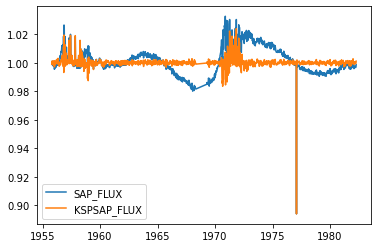

In [16]:
plt.plot(lcfits[1].data['TIME'],lcfits[1].data['SAP_FLUX'],label='SAP_FLUX')
plt.plot(lcfits[1].data['TIME'],lcfits[1].data['KSPSAP_FLUX'],label='KSPSAP_FLUX')
plt.legend()

Let's remind ourselves the period of the stellar system we were examining and the range of time in this lightcurve.

In [17]:
tbl[ind]

APOGEE,Per,M1,M2min,qmin,RAJ2000,DEJ2000,TASOC,QLP
,d,solMass,solMass,,deg,deg,,
str18,float64,float64,float64,float64,float64,float64,bool,bool
2M16132502+2241142,10.44883,1.21682,0.10735,0.08822,243.354251,22.687284,False,True


In [18]:
print(np.max(lcfits[1].data['TIME'])-np.min(lcfits[1].data['TIME']))

26.458879072147965


The period was about 10.4 days; but the QLP lightcurve we downloaded only spans about 26.5 days. It would be best to make use of the multiple datasets available. As our analysis needs get more complicated, it's best to turn to a package that has our downloading, plotting, and analysis tools built in: `lightkurve`.

## Exercise 2

Use the documentation linked above and the [FITS Headers](https://docs.astropy.org/en/stable/io/fits/usage/headers.html) documentation from astropy to answer the following questions:
1. Is the magnitude of this target included, and if so, what is it?
2. Is the mass of this target included, and if so, what is it? How does it compare to the mass determined in the RV catalog?

In [19]:
# Place for code for Exercise 2
# My solutions for Exercise 2:
print(lcfits[0].header['TESSMAG'])
print(lcfits[0].header['MASS'])
print(tbl['M1'][ind])
# The magnitude is 11.9519. 
# The mass is NOT included in the catalog. The mass from the RV catalog is 1.2 stellar masses.

11.9519
-1.0
1.21682


# Combining Multiple Lightcurve Products using lightkurve
The Lightkurve package can also search the MAST archive and download all lightcurve products associated with a target stellar system. As we'll see, this package also is build specifically to plot and work with lightcurves in ways that will be eaiser than the `matplotlib` plotting we were doing above. This portion of the tutorial is based on lightkurve's [Combining multiple quarters of Kepler data](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-combining-multiple-quarters.html) tutorial.

In [20]:
search_result=lk.search_lightcurve(coordstring,author="QLP")
print(search_result)

SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 24 2020    QLP    1800   459321809      0.0
  1 TESS Sector 25 2020    QLP    1800   459321809      0.0


## Downloading the lightcurves

In [21]:
lc_collection=search_result.download_all()
lc_collection

LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 459321809" SECTOR=24 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    1: <TessLightCurve LABEL="TIC 459321809" SECTOR=25 AUTHOR=QLP FLUX_ORIGIN=sap_flux>

By choosing download_all, we create `LightCurveCollection` (basically, an array) of LightCurve products. By examining the first index in the colleciton, we can see that the columns are the same as in the .fits file that we downloaded thorugh `astroquery`, above. 

In [22]:
lc_0=lc_collection[0]
lc_0

time,flux,flux_err,cadenceno,sap_flux,kspsap_flux,kspsap_flux_err,quality,orbitid,sap_x,sap_y,sap_bkg,sap_bkg_err,kspsap_flux_sml,kspsap_flux_lag
,,,,,,,,,pix,pix,,,,
Time,float32,float32,int32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32
1955.826945541731,1.000949740409851,0.0012556471629068255,34961,1.0009497,1.001073,0.0012556472,4096,55,2016.7794189453125,1255.9715576171875,-1068.7,1193.06,1.0002987,1.0009236
1955.8477794857677,0.9993467330932617,0.0012556471629068255,34962,0.99934673,0.99950033,0.0012556472,4096,55,2016.7774658203125,1255.96923828125,-1073.14,1001.74,0.99982256,0.99969786
1955.8686134284446,1.000847578048706,0.0012556471629068255,34963,1.0008476,1.0010757,0.0012556472,4096,55,2016.7772216796875,1255.96875,-1096.99,1192.62,1.0008972,1.0013695
1955.8894473700432,1.0000038146972656,0.0012556471629068255,34964,1.0000038,1.0003434,0.0012556472,4096,55,2016.775634765625,1255.968505859375,-1315.08,1281.6,1.000297,1.0005078
1955.910281310639,0.9998215436935425,0.0012556471629068255,34965,0.99982154,1.0003048,0.0012556472,4096,55,2016.77490234375,1255.966796875,-991.07,988.59,1.0005975,1.0006204
1955.9311152505072,0.9977028965950012,0.0012556471629068255,34966,0.9977029,0.99835354,0.0012556472,0,55,2016.77490234375,1255.9664306640625,-892.5,1145.74,0.99946433,0.99823517
1955.9519491896924,1.0001204013824463,0.0012556471629068255,34967,1.0001204,1.0009605,0.0012556472,0,55,2016.7730712890625,1255.964111328125,-1211.83,1159.65,1.0009403,1.0013255
1955.9727831284401,0.9996472597122192,0.0012556471629068255,34968,0.99964726,1.0006889,0.0012556472,0,55,2016.773681640625,1255.9658203125,-1063.67,1217.9,1.000123,1.0009245


## Plotting the lightcurves
We can use lightkurve's built in plotting feature to assure ourselves that we have downloaded the same dataset as we did above with ```astroquery```. This also helps us confirm that the default column to plot is ```sap_flux```, the one we want for stellar variability.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

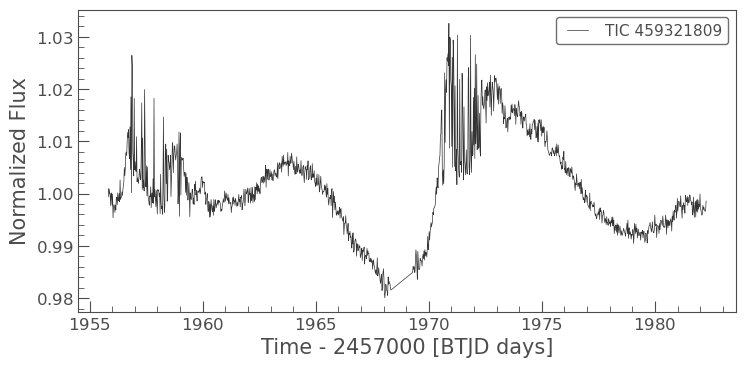

In [23]:
lc_0.plot()

To combine both datasets as one, we can use the built-in stitching method.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

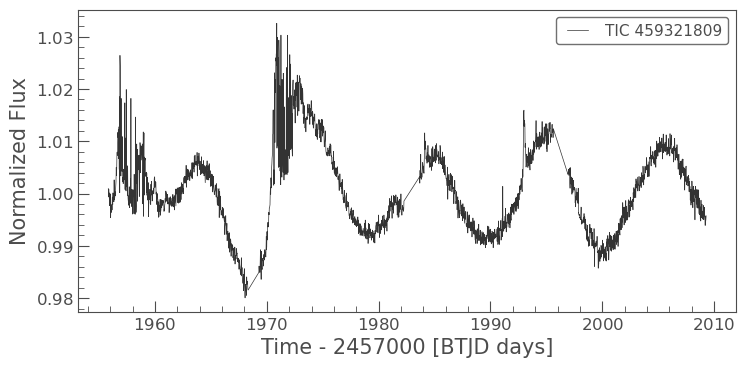

In [24]:
lc_stitched=lc_collection.stitch()
lc_stitched.plot()

## Finding the Period of the Variability using lightkurve
`lightkurve` also has built-in methods for finding the periodicity embedded in the lightcurve; the result is what's known as a periodogram. This portion of the tutorial is based off of the [What are Periodogram objects?](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-periodogram-objects.html#What-are-Periodogram-objects?) and [Creating periodograms and identifying significant peaks](Creating periodograms and identifying significant peaks) tutorials; the second link in particular has more background information about the mathematics behind periodograms.

Below, we create the periodogram object (```pg```), plot it, and print the period that correspond with the maximum power.

<Quantity 10.69171306 d>

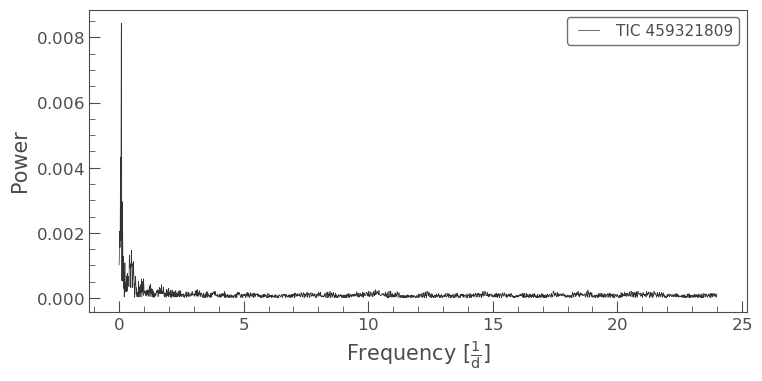

In [25]:
pg=lc_stitched.to_periodogram()
pg.plot()
pg.period_at_max_power

For the types of periods we are interested in (measured in multiple days), the frequency will be very small, so the view above may not be insightful. Below, we  plot the periodogram with the period on the horizontal axis (instead of frequency) and with both axes in a logarithmic scale. On top of the plot, we'll include a vertical line that corresponds with the measured period from Price-Whelan+ 2018.

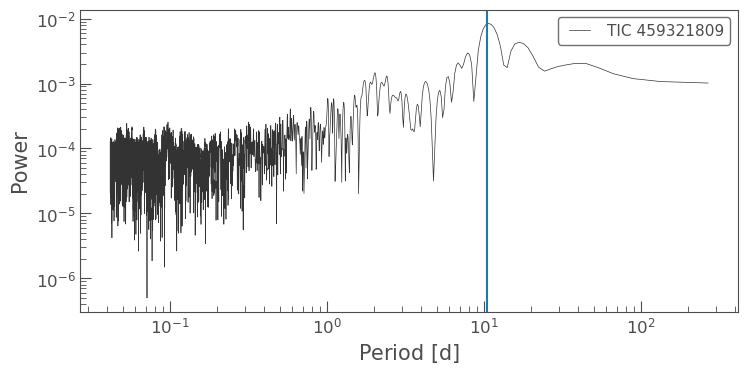

In [26]:
ax=pg.plot(view='period',scale='log')
ax.axvline(tbl['Per'][ind])

Finally, with this period, we can create and view a folded lightcurve. In a folded lightcurve, phase (in Julian days) appears on the horizontal axis instead of time. In other words, the observations are placed by where they appear in the periodic nature of the change. 

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

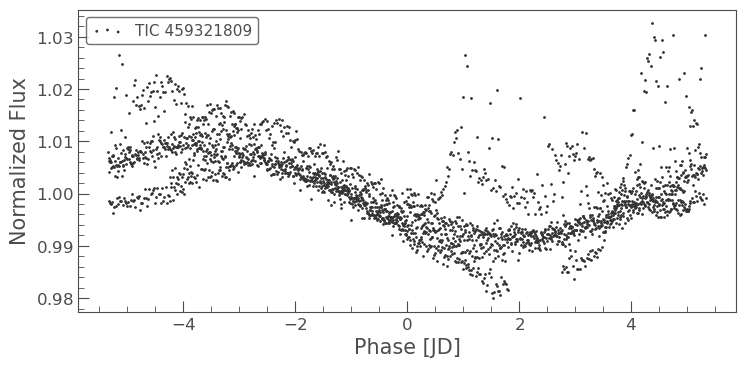

In [27]:
lc_stitched.fold(period=pg.period_at_max_power).scatter()

While we found a period of variability using the eclipse method from TESS lightcurves that nearly matches that determined by the radial velocity method from APOGEE-2 (10.7 vs. 10.4 days), the folded lightcurve above is not very convincing that this period is correct. Examining the folded lightcurves for each observation period separately shows that period seems to be a good match for the second set observing period, but not the first. Moreover, the variability appears more likely to be due to stellar oscillation, not a distinct eclipse! 

JRK is this right? What more to say about that?

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

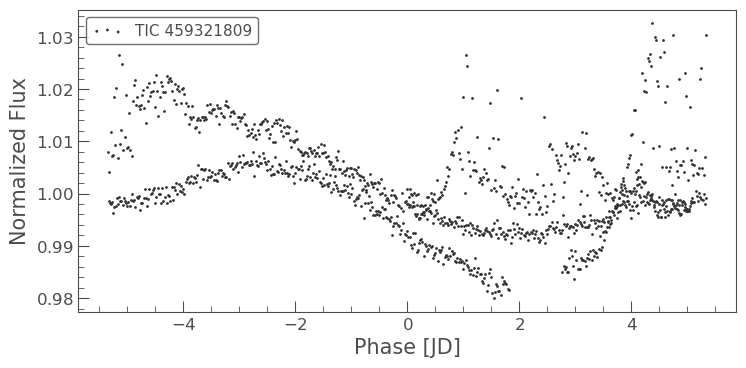

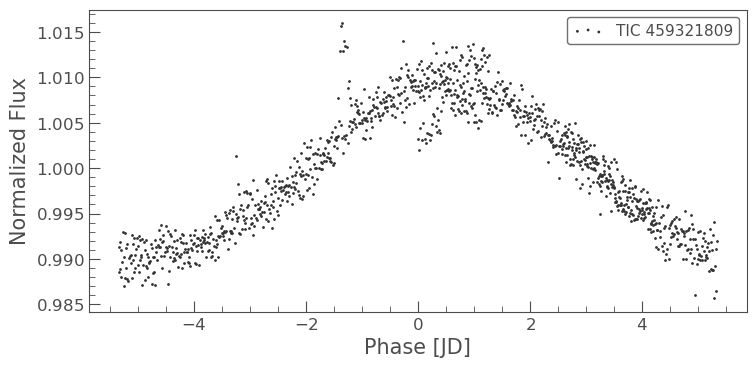

In [28]:
lc_collection[0].fold(period=pg.period_at_max_power).scatter()
lc_collection[1].fold(period=pg.period_at_max_power).scatter()

## Additional Exercises
>Exercises are optional, but encouraged. Exercises can be woven into the main content of your tutorial, or appear in their own section toward the end of the tutorial. Final exercises can be more challenging, similar to homework problems. They can be minimal or take as long as 30 minutes to an hour to complete. If you do have one or more exercises in your tutorial, be sure to leave a blank code cell underneath each to show the reader that they're meant to try out their new skill right there. You may also want to include a "solutions" notebook next to your main notebook for the reader to check their work after they have finished their attempt.

Exercise ideas:
- Use lk.search_lightcurve to loop through a subset of the Price-Whelan+ 2018 tables to find which have QLP observations.
- Try examining the lightcurves of the stellar systems in Table 5 of Price-Whelan+ 2018 (those that have two possible sets of system properties). Can the TESS lightcurves narrow down the systems to one set of properties? (JRK this is super open ended but also super interesting.)

## Additional Resources

>This section is optional. Try to weave resource links into the main content of your tutorial so that they are falling in line with the context of your writing. For resources that do not fit cleanly into your narrative, you may include an additional resources section at the end of your tutorial. Usually a list of links using Markdown bullet list plus link format is appropriate:

- [Astroquery:docs, VizieR Queries](https://astroquery.readthedocs.io/en/latest/vizier/vizier.html)

JRK Update

## About this Notebook
>Let the world know who the author of this great tutorial is! If possible and appropriate, include a contact email address for users who might need support (for example, `archive@stsci.edu`). You can also optionally include keywords, your funding source, or a last update date in this section.

**Author:** Julia Kamenetzky, ScienceBetter Consultant
**Updated On:** YYYY-MM-DD

## Citations
>Provide your reader with guidelines on how to cite open source software and other resources in their own published work.

If you use `astropy`, `lightkurve`, or `VizieR` for published research, please cite the
authors. Follow these links for more information about citing these tools:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* [Citing `VizieR`](https://cds.unistra.fr/vizier-org/licences_vizier.html?#copyrightvizier)

JRK add astroquery, MAST separately?

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 